In [827]:
import pandas as pd
import numpy as np
from scipy import sparse
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import decomposition, datasets, model_selection, preprocessing, metrics


In [828]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [829]:
import rainbow
import os
import glob

## Import the jsonified transactions into a dataframe

In [830]:
path = '/Users/Sarah/galvanize/dsi-capstone/jsons/'
all_files = glob.glob(os.path.join(path, "*.json"))

In [831]:
df = pd.concat((pd.read_json(f,keep_default_dates=False,lines=True) for f in all_files)) 

## Import just one day into a dataframe 

In [778]:
#df=pd.read_json('./jsons/1.json',keep_default_dates=False,lines=True)

In [779]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73865 entries, 0 to 3052
Data columns (total 10 columns):
date      73865 non-null object
gross+    73865 non-null float64
gross-    73865 non-null float64
items     73865 non-null object
net       73865 non-null float64
oper      73865 non-null int64
term      73865 non-null int64
time      73865 non-null object
trans     73865 non-null int64
type      73865 non-null object
dtypes: float64(3), int64(3), object(4)
memory usage: 6.2+ MB


In [837]:
def get_items(df,most_common=10,least_common=5):
    df['total_of_items'] = 0
    stoppers = ['BAG CREDIT','SF Bag Charge','Gift Card Reload','8 OZ BIO TUB t3', '16OZ BIO TUB t4',
                 '32OZ BIO TUB t5','BOTTLE DEPOSIT','6PACK BEER SMALL C','PAID IN','Gift Card Sale','PACKAGED FOOD', ]  
    '''build a dictionary where the keys are the words
    in the dataframe items column'''
    
    items=[]
    item_dict = defaultdict(int)
    basket_counts=[]
    
    for basket in df['items']:
        basket_counts.append(len(basket))
        for item in basket:
            if item[3]!=12:
                items.append(item[1])
                item_dict[item[1]] += 1
    
    items_set=set(items)

    
    '''add the most common words to the stopwords list'''
    stopwords=list([i[0] for i in Counter(item_dict).most_common(most_common)])
    
    for s in stoppers:
        stopwords.append(s)
        
    '''add items containing "CRV" to the stopwords list'''
    for item in items_set:
        if "crv" in item.lower():
            stopwords.append(item)
    
    '''add the least common words to the stopwords list'''
    for key,value in item_dict.items():
        if value < least_common:
            stopwords.append(key)
    print(type(stopwords) )  
    stopwords = set(stopwords)
    
    '''iterate through the baskets and add items to items_set
    if not in stopwords (too common or too uncommon)'''
    for stops in stopwords:
        items_set.remove(stops)
  

    return items_set,stopwords, item_dict, basket_counts

items_set,stopwords,item_dict, basket_counts = get_items(df,most_common=5,least_common=5)

<class 'list'>


In [838]:
Counter(item_dict).most_common(25)

[('BAG CREDIT', 58565),
 ('SF Bag Charge', 15698),
 ('SMALL COOLER CRV', 13042),
 ('8 OZ BIO TUB t3', 5004),
 ('CRV LRG SING NOTAX', 4439),
 ('CRV SMALL SING T', 4433),
 ('CRV SMALL NO TAX', 3798),
 ('Worker 20% PkgFood', 3523),
 ('16OZ BIO TUB t4', 3500),
 ('BOTTLE DEPOSIT', 3146),
 ('LARGE COOLER CRV', 3064),
 ('BEER SMALL CRV', 2913),
 ('BAGEL', 2774),
 ('CRV LRG SING T', 2652),
 ('Worker 20% Refrig', 2322),
 ('5290 WALNUTS', 1738),
 ('REFRIGERATED', 1732),
 ('4110 ORG RLD OATS', 1672),
 ('MILTON CHEDDAR', 1502),
 ('PACKAGED FOOD', 1451),
 ('SMALL REF CRV TAX', 1278),
 ('Worker 20% Bakery', 1259),
 ('BAKERY', 1227),
 ('Worker 20% Bulk', 1153),
 ('6PACK BEER SMALL C', 1129)]

In [839]:
df['item_count']=basket_counts

In [783]:
percentile = np.percentile(basket_counts, [25, 50, 75])
q1=percentile[0]
q2=percentile[1]
q3=percentile[2]

dfq1=df[(df['item_count']<=q1)]
dfq2=df[(df['item_count']>q1 )& (df['item_count']<=q2)]
dfq3=df[(df['item_count']>q2 )& (df['item_count']<=q3)]
dfq4=df[df['item_count']>q3]
df_avg=df[(df['item_count']>=10 )& (df['item_count']<=12)]

In [784]:
q1,q2,q3

(3.0, 8.0, 16.0)

In [785]:
df = df_avg

In [840]:
df['item_count'].max()

156

In [841]:
item_matrix = np.zeros((df.shape[0],len(items_set)))

In [842]:
df_items= pd.DataFrame(item_matrix,columns=items_set)

In [843]:
df.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            3043, 3044, 3045, 3046, 3047, 3048, 3049, 3050, 3051, 3052],
           dtype='int64', length=73865)

In [844]:
df=df.reset_index()

In [845]:
df.index

RangeIndex(start=0, stop=73865, step=1)

In [846]:
df.describe()

,index,gross+,gross-,net,oper,term,trans,total_of_items,item_count
count,73865.000000,73865.000000,73865.000000,73865.000000,73865.000000,73865.000000,73865.000000,73865.0,73865.000000
mean,1331.635714,119.707593,4.104208,115.603385,129.191782,4.843986,147.200149,0.0,11.241576
std,784.366767,503.477908,88.814536,482.132335,350.556723,2.951749,106.353866,0.0,11.739385
min,0.000000,0.000000,0.000000,-521.080000,1.000000,1.000000,1.000000,0.0,0.000000
25%,659.000000,13.500000,0.000000,13.010000,27.000000,2.000000,61.000000,0.0,3.000000
50%,1319.000000,39.330000,0.000000,38.620000,60.000000,5.000000,128.000000,0.0,8.000000
75%,1978.000000,87.430000,0.000000,85.700000,79.000000,7.000000,215.000000,0.0,16.000000
max,3131.000000,14257.890000,7539.930000,13755.450000,1745.000000,11.000000,583.000000,0.0,156.000000


In [847]:
df.pop('index')
print ()

In [848]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73865 entries, 0 to 73864
Data columns (total 12 columns):
date              73865 non-null object
gross+            73865 non-null float64
gross-            73865 non-null float64
items             73865 non-null object
net               73865 non-null float64
oper              73865 non-null int64
term              73865 non-null int64
time              73865 non-null object
trans             73865 non-null int64
type              73865 non-null object
total_of_items    73865 non-null int64
item_count        73865 non-null int64
dtypes: float64(3), int64(5), object(4)
memory usage: 6.8+ MB


In [849]:
df.iloc[:,0].index


RangeIndex(start=0, stop=73865, step=1)

In [850]:
df_items.iloc[:,0].index

RangeIndex(start=0, stop=73865, step=1)

In [851]:
col_index_dict = dict(zip(items_set, range(len(items_set))))

In [852]:
#col_index_dict

In [853]:
matrix = np.zeros(df_items.shape)
matrix.shape

(73865, 12957)

In [854]:
    for i in range(df.shape[0]):
        for item in df['items'][i]:
            #set matrix to boolean for item precence in basket:
            if item[1] not in stopwords and item[3] != 12:
                matrix[i,col_index_dict[ item[1] ]] = matrix[i,col_index_dict[ item[1] ]] + item[2]
            '''if item[1] not in stopwords and item[2] > 0:
                matrix[i,col_index_dict[ item[1] ]] = 1
            if item[1] not in stopwords and item[2] < 0:
                matrix[i,col_index_dict[ item[1] ]] = 0'''
    #matrix = (matrix > 0).astype(int)
 

In [855]:
#count rows of baskets with a total of 0 weight items
sum_of_zeros=0
for i in range(matrix.shape[0]):
    if matrix[i].sum()<1:
        sum_of_zeros+=1
print (sum_of_zeros)

11092


In [856]:
print(sum_of_zeros / matrix.shape[0],"% of zero weight baskets")

0.15016584309212752 % of zero weight baskets


In [857]:
#Set all negative values in the matrix to 0.

matrix = (matrix > 0).astype(int)

In [858]:
matrix.shape[0]

73865

In [859]:
sparse_matrix = sparse.csr_matrix(matrix)

In [860]:
sparse_matrix

<73865x12957 sparse matrix of type '<class 'numpy.int64'>'
	with 395330 stored elements in Compressed Sparse Row format>

In [611]:
from sklearn import decomposition, datasets, model_selection, preprocessing, metrics

In [480]:
def nmf_funct(sparse_matrix,n_components=10):
    from sklearn.decomposition import NMF
    model = NMF(n_components=n_components,max_iter=500)
    W = model.fit_transform(sparse_matrix)
    H=model.components_
    model_iter = model.n_iter_
    return model,W,H,model_iter

In [405]:
for i in range(1,25,5):
        iter=i
        iteration,score,model_iter = scoring(iter,sparse_matrix,matrix)
        print(iteration,score)
        scores.append([iteration,score,model_iter])

1 0.0001431933907664586
6 0.00013688176105176462
11 0.00013384672786558588
16 0.00013140280763105445
21 0.0001291768748997968


In [406]:
just_scores=[]
for s in range(len(scores)):
    just_scores.append(scores[s][1])


In [407]:
scores

[[1, 0.0014292479840451004],
 [2, 0.0014154504580593179],
 [3, 0.0014032661542237052],
 [4, 0.0013923321477350976],
 [5, 0.0013824216984958816],
 [6, 0.0013728834602767983],
 [7, 0.0013635799643995552],
 [8, 0.0013551235423484526],
 [9, 0.001346863101037918],
 [10, 0.0013386838095089419],
 [11, 0.001330587590839945],
 [12, 0.0013223004563320056],
 [13, 0.001314240614156265],
 [14, 0.0013069591545129928],
 [15, 0.0013000231686138171],
 [16, 0.0012930671499918533],
 [17, 0.0012869543212667915],
 [18, 0.001280833991894081],
 [19, 0.0012742805405896848],
 [20, 0.0012679189158443943],
 [21, 0.001262182111047437],
 [22, 0.0012566705248991837],
 [23, 0.0012504598340663843],
 [24, 0.0012443260574233738],
 [1, 0.001462029804203652, 5],
 [6, 0.0013877529690621115, 95],
 [11, 0.0013427198413541964, 96],
 [16, 0.0013029291315034713, 292],
 [21, 0.0012701763318097284, 243],
 [1, 0.0001431933907664586, 6],
 [6, 0.00013688176105176462, 67],
 [11, 0.00013384672786558588, 86],
 [16, 0.00013140280763105

In [408]:
just_scores

[0.0014292479840451004,
 0.0014154504580593179,
 0.0014032661542237052,
 0.0013923321477350976,
 0.0013824216984958816,
 0.0013728834602767983,
 0.0013635799643995552,
 0.0013551235423484526,
 0.001346863101037918,
 0.0013386838095089419,
 0.001330587590839945,
 0.0013223004563320056,
 0.001314240614156265,
 0.0013069591545129928,
 0.0013000231686138171,
 0.0012930671499918533,
 0.0012869543212667915,
 0.001280833991894081,
 0.0012742805405896848,
 0.0012679189158443943,
 0.001262182111047437,
 0.0012566705248991837,
 0.0012504598340663843,
 0.0012443260574233738,
 0.001462029804203652,
 0.0013877529690621115,
 0.0013427198413541964,
 0.0013029291315034713,
 0.0012701763318097284,
 0.0001431933907664586,
 0.00013688176105176462,
 0.00013384672786558588,
 0.00013140280763105445,
 0.0001291768748997968]

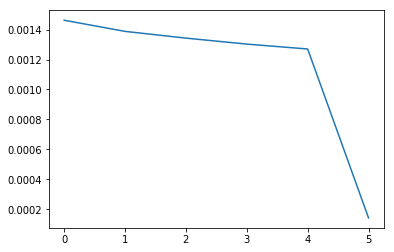

In [409]:
plt.plot(np.arange(len(just_scores[24:30])),(just_scores[24:30]))


In [722]:
scores[24:30]

[[1, 0.001462029804203652, 5],
 [6, 0.0013877529690621115, 95],
 [11, 0.0013427198413541964, 96],
 [16, 0.0013029291315034713, 292],
 [21, 0.0012701763318097284, 243],
 [1, 0.0001431933907664586, 6]]

In [411]:
for i in range(10,101,10):
    iter=i
    print (iter)

10
20
30
40
50
60
70
80
90
100


In [72]:
rebuilt = np.dot(W,H)

NameError: name 'W' is not defined

(73865, 4222)

In [105]:
rebuilt.shape

(73865, 4230)

In [106]:
matrix.shape

(73865, 4230)

In [108]:
rebuilt-matrix

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.29976971e-04, 3.29969297e-04, 2.11526977e-04, ...,
        1.46095233e-04, 9.08517333e-04, 6.24379430e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.05683634e-05, 7.16348659e-05, 8.00710503e-05, ...,
        4.00441875e-05, 2.78065699e-04, 2.19722093e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [121]:
np.mean((rebuilt-matrix)**2)

0.09009532798915376

n_components:
1   =  .0001
2   = 0.0013937693036813904
3   = 0.001383618220432841
10  = 0.0013233378763788833
100 =-0.0003337663571822616
100 = 0.001324181632724416

In [129]:
scorer=metrics.explained_variance_score
prediction = model.inverse_transform(model.transform(sparse_matrix))
scorer(matrix, prediction)

0.018682112359056913

In [130]:
prediction


array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.29976672e-04, 3.29950574e-04, 2.11518553e-04, ...,
        1.46131375e-04, 9.08533609e-04, 6.24109411e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.05695823e-05, 7.16348761e-05, 8.00711799e-05, ...,
        4.00437082e-05, 2.78061313e-04, 2.19714633e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [868]:
from sklearn.decomposition import NMF
model = NMF(n_components=2,max_iter=250)
W = model.fit_transform(sparse_matrix)
H=model.components_
model_iter = model.n_iter_
model,W,H,model_iter

(NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=250,
   n_components=2, random_state=None, shuffle=False, solver='cd',
   tol=0.0001, verbose=0), array([[0.00019067, 0.00013762],
        [0.00047669, 0.        ],
        [0.        , 0.        ],
        ...,
        [0.        , 0.        ],
        [0.01022985, 0.00810024],
        [0.        , 0.        ]]), array([[0.00158789, 0.00739191, 0.00474234, ..., 0.00097156, 0.02163554,
         0.01265057],
        [0.00311661, 0.        , 0.00278109, ..., 0.00336641, 0.01655538,
         0.00334836]]), 33)

In [869]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
LDA_model = LDA(n_components=2,max_iter=10)
LDA_W = model.fit_transform(sparse_matrix)
LDA_H = model.components_


In [870]:
list(items_set)[1000]

'NO AHCC 500mg 60vc'

In [871]:
feature_names=list(items_set).copy()
n_top_words=20
for topic in H:
    print(topic.argsort()[:-n_top_words - 1:-1])
    print ([feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]])
    print()

[ 9801  2147  3143  8297  4554  7197  1712  8457 11509  4088 11874  2280
 10619  6326  1981  6916 12780  3835  3600  2042]
['5290 WALNUTS', '4110 ORG RLD OATS', 'MILTON CHEDDAR', '5120 ORG ALMONDS', '3185 ORG MANGO', 'REFRIGERATED', '5150 BRAZIL NUTS', '6645 SUNFLWR SEEDS', '5250 ORG PECAN HA', '5180 WHOLE CASHEWS', '2448 CASTEL OLIVE', 'PARADISO VINTAGE', 'WHOLE ORG MILK', '4125 OG STL CUT OA', 'PARMIGIANO REGG', 'EGGS DZ ST JOHN', '2195 ORG GARBANZO', '3080 MEDJOOL DATES', '5452 ORG PNUT BUTR', '2220 ORG RED LNTL']

[ 5032  1801  9657  4554  7197 10619  8019  2280  7892  7386   724 11615
  3449  9465  1639 12713   770  4443 10412  8210]
['BAGEL', 'BAKERY', 'OV CRM CHEESE SPRE', '3185 ORG MANGO', 'REFRIGERATED', 'WHOLE ORG MILK', 'GINA MARIE CC', 'PARADISO VINTAGE', 'OV CREAM CHEESE', 'STRAUS MILK 64oz', 'MONTEREY JACK CHEE', 'ESTHERS PRETZELS', 'ORG 1LB BUTTER', 'SIERRA ORG CC TUB', '3680 BAKERS CH FLO', 'STRAUS PLN YOG QT', 'CLO UNSALTED BUTTE', 'ORG WM QT CLOVER', 'TILLY SHARP CHED

Topic #0:
['5290 WALNUTS', '4110 ORG RLD OATS', 'MILTON CHEDDAR', '5120 ORG ALMONDS', '3185 ORG MANGO', 'REFRIGERATED', '5150 BRAZIL NUTS', '6645 SUNFLWR SEEDS', '5250 ORG PECAN HA', '5180 WHOLE CASHEWS', '2448 CASTEL OLIVE', 'PARADISO VINTAGE', 'WHOLE ORG MILK', '4125 OG STL CUT OA', 'PARMIGIANO REGG', 'EGGS DZ ST JOHN']


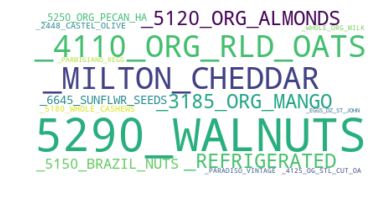

Topic #1:
['BAGEL', 'BAKERY', 'OV CRM CHEESE SPRE', '3185 ORG MANGO', 'REFRIGERATED', 'WHOLE ORG MILK', 'GINA MARIE CC', 'PARADISO VINTAGE', 'OV CREAM CHEESE', 'STRAUS MILK 64oz', 'MONTEREY JACK CHEE', 'ESTHERS PRETZELS', 'ORG 1LB BUTTER', 'SIERRA ORG CC TUB', '3680 BAKERS CH FLO', 'STRAUS PLN YOG QT']


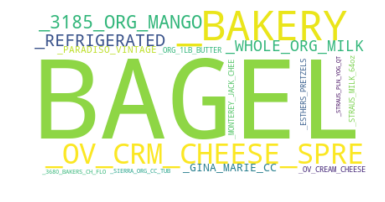

In [875]:
def print_top_items(model, feature_names, n_top_words):
    topic_dict = defaultdict()
    topics =[]
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        #topic_string=(" ".join([feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]]))
        topic_string=[feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_dict[topic_idx]=topic_string
        topics.append(topic_string)
        print(topic_string)
        #print()
        wordcloud = WordCloud(max_font_size=500, max_words=1000, background_color="white").generate(str(topic_string).replace(" ", "_").replace("'",""))

        # Display the generated image:
        #plt.figure(1,figsize=(10,10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        #plt.savefig('topic%d.png'%topic_idx)
        #plt.close()
        wordcloud.to_file('topic%d.png'%topic_idx)
    return topic_dict
topics = print_top_items(model,list(items_set),16)
#print("stopwords:",stopwords,"number of topics:",len(topics))

In [873]:
topics3=topics.copy()

In [874]:
topic_compare =np.zeros([len(topics),len(topics)])

for topic in topics:
    for item in topics[topic]:
        for topic2 in topics:
            #print (item)
            #print (type(topics[topic2]))
            if item in topics[topic2]:
                topic_compare[topic,topic2]+=1
            
topic_compare


array([[25.,  6.],
       [ 6., 25.]])

In [817]:
list_of_topics=[]
for topic in topics:
     list_of_topics.append(topics[topic])

In [818]:
len(topics[0])

25

In [819]:
ingredients =np.array((len(topics),len(topics[0])))
for row in topics:
    print('row',row)
    for i,item in enumerate(topics[row]):
        if item not in topics[row]:
            print ('i',i,item)
            
        if item not in topics[0]:
            print ('iI',i,item)
        #ingredients[row:i]=item
ingredients

row 0
row 1
iI 0 5290 WALNUTS
iI 1 5250 ORG PECAN HA
iI 2 2371 EQUAL EX COFF
iI 3 5180 WHOLE CASHEWS
iI 4 3290 THOMPSON RAIS
iI 5 BETTER HALF UNSWT
iI 6 3144 OG DR CRANBER
iI 7 3486 SLICED ALMOND
iI 8 PARMIGIANO REGG
iI 9 2238 HIMA PINK SAL
iI 10 STARTER Pastry
iI 11 5120 ORG ALMONDS
iI 12 acme pan au levain
iI 13 SPANISH FIG CAKE
iI 14 6075 FRESH RAVIOLI
iI 15 ORG Y CORN TORT
iI 16 8106 CHAMOMILE ORG
iI 17 7772 ALMOND BUTTR
iI 18 6310 OG LG BR RICE
iI 19 5275 RST PISTACHI
iI 20 STRAUS PLN YOG QT
iI 21 ACME BAGUETTE
iI 22 5200 RAW HAZELNUTS
iI 23 6985 OLIVEANTIPAST
iI 24 4140 ORGANIC POPCO
row 2
iI 0 REFRIGERATED
iI 1 INDIAN BENTO
iI 2 SPICY HUMMUS
iI 3 BREAKFAST BURRITO
iI 4 LL TEMPEH
iI 5 NIRVANA KITCHEN
iI 6 SEMIFREDDIS BAGUET
iI 7 STRAUS GREEK YOGUR
iI 8 ORG MILK FF QT
iI 9 XL DUCK EGGS
iI 10 PESTO PASTA
iI 11 3290 THOMPSON RAIS
iI 12 OLIPOP STRAW VANIL
iI 13 7TH GEN TP 500CT
iI 14 SAVVY SAVORIES
iI 15 2890SESAME STIKS
iI 16 VEGETABLE BARLEY
iI 17 CHOCO HAZELNUT CUP
iI 18 BULK
iI 1

array([16, 25])

In [820]:
len(ing_set)

NameError: name 'ing_set' is not defined

In [821]:
ing_index_dict = dict(zip(ing_set, range(len(ing_set))))

NameError: name 'ing_set' is not defined

In [822]:
ingredients=np.array(ingredients)
ingredients=ingredients.reshape(5,55)

ValueError: cannot reshape array of size 2 into shape (5,55)

In [823]:
ingredients.shape

(2,)

In [234]:
ing_matrix=np.zeros(ingredients.shape)

In [824]:
for row,col in enumerate(ingredients):
    for i,c in enumerate(col):
        #print(row,i,c)
        ing_matrix[row,i]=ing_index_dict[c]
ing_matrix

TypeError: 'numpy.int64' object is not iterable

In [255]:
ing_array=ing_index_dict.values()

ing_array

dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134])

In [259]:
for i in ing_matrix:
    print(ing_array==i)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False

In [226]:
for ing_index_dict

{'SPINACH BUNCHED': 0,
 'POTATOES YELLOW': 1,
 'ROOTS TURNIP LOOSE': 2,
 'POTATOES RUSSET': 3,
 'SATSUMA MANDARIN': 4,
 'ORGANIC 2% MILK': 5,
 'PARMIGIANO REGGIAN': 6,
 'ORG 1LB BUTTER': 7,
 'BAG PINK LADY APPL': 8,
 '4110 ORG RLD OATS': 9,
 'TOMATO MIX HEIRLOO': 10,
 'GREEN ONIONS': 11,
 'BRUSSEL SPROUTS': 12,
 'PEAR BOSC': 13,
 'ONIONS GREEN': 14,
 'KALE GREEN': 15,
 'ORANGES BLOOD': 16,
 'CHARD RAINBOW': 17,
 'POTATOES RED': 18,
 'MUSHROOM CRIMINI': 19,
 'CUCUMBERS ENGLISH': 20,
 'PARSLEY ITALIAN': 21,
 'BLUEBERRIES': 22,
 'BROCCOLI BABY SWEE': 23,
 'CLO UNSALTED BUTTE': 24,
 'DAIKON WATERMELON': 25,
 '2215 ORGANIC LENTI': 26,
 'GRAPEFRUIT': 27,
 'RADDICHIO': 28,
 'BOK CHOY BABY': 29,
 'PEPPERS GREEN BELL': 30,
 'ORG WM QT CLOVER': 31,
 'ONIONS RED': 32,
 'STRAUS PLN YOG QT': 33,
 'EGGS DZ ST JOHN': 34,
 'KALE DINO': 35,
 '3080 MEDJOOL DATES': 36,
 'CELERY': 37,
 'CAULIFLOWER CELLO': 38,
 'EGGPLANT GLOBE': 39,
 'DAIKON': 40,
 'TOMATOES ROMA': 41,
 'LIMES': 42,
 'CHARD RED': 43,
 'BA

In [825]:
def print_basket_contents(basket_id):
    basket=[]
    #print('+++++++++++++++++++++++next basket+++++++++++++++++')
    for items in df['items'][basket_id]:
        #for item in items:
        print("item:",items)
    #return basket
#print_basket_contents(1116)

In [826]:
def print_top_baskets(model, W, n_top_words):
    baskets = []
    for topic_idx, w in enumerate(W.T):
        basket_string=str([df['items'][i] for i in w.argsort()[:-n_top_words - 1:-1]])
        count = 0
        for i in w.argsort()[:-n_top_words - 1:-1]:
            count+=1
            print("++++++++++++++++++Topic #%d, basket #%d+++++++++++++++++++"%(topic_idx,count))
            print_basket_contents(i)
        #print_basket_contents([i for i in w.argsort()[:-n_top_words - 1:-1]])
        baskets.append(basket_string)
        #print(basket_string)
        #print()
        '''wordcloud = WordCloud(max_font_size=500, max_words=1000, background_color="white").generate(basket_string.replace(" ", "_").replace("'",""))

        # Display the generated image:
        #plt.figure(1,figsize=(10,10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        #plt.savefig('topic%d.png'%topic_idx)
        #plt.close()
        wordcloud.to_file('topic%d.png'%topic_idx)'''
print_top_baskets(model,W,10)

++++++++++++++++++Topic #0, basket #1+++++++++++++++++++
item: ['', 'THTWN VANILLA', 5.69, 19]
item: ['', 'NANCY 32oz YOGURT', 5.59, 13]
item: ['', '8 OZ BIO TUB t3', 0.30000000000000004, 36]
item: ['', '5352 ALMOND BUTTER', 3.96, 16]
item: ['', 'BAGEL', 1.25, 17]
item: ['', 'BAGEL', 1.25, 17]
item: ['', 'SU OptiPak Ea Pak', 1.99, 1]
item: ['', 'ORANGES BLOOD', 3.67, 12]
item: ['', 'BANANAS', 3.11, 12]
item: ['', '2733 EQUATOR COFFE', 5.09, 16]
item: ['', 'APPLE FRITTER', 3.99, 17]
++++++++++++++++++Topic #0, basket #2+++++++++++++++++++
item: ['', 'DISH LIQUID 25oz', 3.99, 7]
item: ['', 'NANCY 32oz YOGURT', 4.99, 13]
item: ['', '8 OZ BIO TUB t3', 0.30000000000000004, 36]
item: ['', '5352 ALMOND BUTTER', 4.48, 16]
item: ['', 'ORANGES BLOOD', 2.63, 12]
item: ['', '2427 UBUNTU COFFEE', 4.05, 16]
item: ['', 'MANDERINE GOLD NU', 0.81, 12]
item: ['', 'SU OptiPak Ea Pak', 1.99, 1]
item: ['', 'BANANAS', 1.26, 12]
item: ['', 'APPLE FRITTER', 3.99, 17]
item: ['', 'BAGEL', 2.5, 17]
item: ['MR', 

item: ['', '3185 ORG MANGO', 1.82, 16]
item: ['', '5595 HIT TRAIL MX', 3.1, 16]
item: ['', '2998 BUCKY GRANOLA', 2.79, 16]
item: ['', '2954 FIG BARS', 1.78, 16]
item: ['MP', 'BAG CREDIT', -0.1, 23]
++++++++++++++++++Topic #6, basket #2+++++++++++++++++++
item: ['', 'PAPER PARA CARD', 4.99, 8]
item: ['', 'WECK LARGE COVER', 1.19, 6]
item: ['', '3130 DRD BANANA', 1.5, 16]
item: ['', '2889 ENERGY CHUNKS', 1.7000000000000002, 16]
item: ['', '3185 ORG MANGO', 2.7199999999999998, 16]
item: ['', '3065 COCONUT FLAKE', 1.01, 16]
item: ['', '2887 ENERGY CHUNKS', 1.88, 16]
item: ['', 'LAVVA VANILLA', 2.49, 13]
item: ['', 'ORANGES NAVEL', 2.95, 12]
item: ['MP', 'BAG CREDIT', -0.1, 23]
++++++++++++++++++Topic #6, basket #3+++++++++++++++++++
item: ['MP', 'BAG CREDIT', -0.55, 23]
item: ['', '4110 ORG RLD OATS', 8.66, 16]
item: ['', '4110 ORG RLD OATS', 9.06, 16]
item: ['', '3185 ORG MANGO', 6.7, 16]
item: ['', '3245 DRD PINEAPPLE', 13.05, 16]
item: ['', '3065 COCONUT FLAKE', 5.6, 16]
item: ['', '317

item: ['', 'Aloe Vera Gel 16oz', 4.8, 4]
item: ['VD', 'Aloe Vera Gel 16oz', -4.8, 4]
item: ['', 'Lily D Aloe Gel', 3.36, 4]
item: ['', 'NW Valerian 100cap', 7.49, 1]
item: ['', '2371 EQUAL EX COFF', 5.83, 16]
item: ['', '4140 ORGANIC POPCO', 1.25, 16]
item: ['', '2580 NUTRI YEAST', 2.0, 16]
item: ['', '8352 MACE POWDER', 4.08, 11]
item: ['', '2349 CA BEE POLLEN', 3.08, 16]
item: ['MP', 'BAG CREDIT', -0.2, 23]
++++++++++++++++++Topic #13, basket #7+++++++++++++++++++
item: ['', 'UNSWEETENED RIPPLE', 4.49, 13]
item: ['', 'LARGE COOLER CRV', 0.1, 13]
item: ['MP', 'BAG CREDIT', -0.1, 23]
item: ['', '6330 COM SG B RICE', 2.17, 16]
item: ['', '2180 ORG BLK BEANS', 2.62, 16]
item: ['', '2580 NUTRI YEAST', 1.8399999999999999, 16]
item: ['', 'NW NutraVege O3 ZL', 15.99, 1]
item: ['', '2180 ORG BLK BEANS', 2.43, 16]
item: ['', '8597 VITC BIOFLAV', 2.2800000000000002, 31]
item: ['', '6541 BRWN FLAXMEAL', 0.8, 16]
item: ['', '6546 CHIA GROUND', 1.09, 16]
item: ['', '8538 SPIRULINA ORG', 2.43, 31]


In [427]:
df['item_count'].max()

2

In [ ]:
W[:,1]

In [ ]:
n_top_words=10
for i,w in enumerate(W.T):
    print(i,w.argsort()[:-n_top_words - 1:-1])

In [76]:
len(list(items_set))

6576

In [75]:
for topic in H:
    print (topic.argsort()[:-10-1:-1])

[1752 6585 2198 2188 2189 2190 2191 2192 2193 2194]
[1271 6539 4820   80 4966 1929 2604 6546 2660 4806]
[6114 3455  640 2958  537   84 2189 4025 1017 4051]
[3058 2646 2476 5751 5768 6309 4302 4243 3450 6388]
[1484 4994 5017  125 4381  102 1207  435 1811 4079]


In [ ]:
feat
str([feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]])

In [72]:
df.shape[0]
for i in range(10,11):
    row = df['items'][i:i+1]
    for item in row:
        for it in item:
            print (it[1],it[2])

4112 SINTO KIMCHI 13.54
PEPPERS RED BELL 2.75
CUCUMBERS 12.73
ORGANIC 2LB TOFU 20.95
5540 TAHINI 12.17
GINGER 4.79
GARLIC WHITE 3.01
PRODUCE SCALE 1.79
LIMES 2.0
CILANTRO 1.99
CILANTRO 1.99
BROCCOLI LOOSE 6.24
CELLO CAULIFLOWER 11.96
LEEKS 9.12
SUGAR PLUM CLAM 5.97
BEETS RED LOOSE 6.01
store 100% Bulks -34.5
store 100% Produce -70.35
store 100% Refrig -20.95


In [12]:
df.shape[0]
for i in range(10,11):
    row = df['items'][i:i+1]
    for item in row:
        for it in item:
            df[it[1]][i:i+1]=df[it[1]][i:i+1]+it[2]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
df['CILANTRO'][10:11]

10    3.98
Name: CILANTRO, dtype: float64

In [19]:
df.shape[0]
for i in range(1,df.shape[0]):
    row = df['items'][i:i+1]
    for item in row:
        for it in item:
            df[it[1]][i:i+1]=df[it[1]][i:i+1]+it[2]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
df.shape

(2535, 6586)

In [22]:
df.to_pickle('02012019.pkl')

In [213]:
len(items_set)

6576

In [114]:
trans = []
for a in df[1:2]['items']:
    #trans.append([r for v in a for r in v])
    trans.append(a)
print(a)

[['', 'BLUEBERRIES', 5.99, 12], ['', 'ALXNDRE YOGURT', 4.99, 13], ['MP', 'Worker 20% Produce', -1.2, 12], ['MP', 'Worker 20% Refrig', -1.0, 13]]


In [96]:
trans =[]
for l in [i for i in df[1:2]['items']]:
    print (l)
    trans.append(l)
    print (trans)

[['', 'BLUEBERRIES', 5.99, 12], ['', 'ALXNDRE YOGURT', 4.99, 13], ['MP', 'Worker 20% Produce', -1.2, 12], ['MP', 'Worker 20% Refrig', -1.0, 13]]
[[['', 'BLUEBERRIES', 5.99, 12], ['', 'ALXNDRE YOGURT', 4.99, 13], ['MP', 'Worker 20% Produce', -1.2, 12], ['MP', 'Worker 20% Refrig', -1.0, 13]]]


In [4]:
#pd.get_dummies([i for i in df[1:2]['items']]).values()

In [80]:

type(df['items'].values)
count=0
for document in df['items'][1]:
    print (document)
    
    for word in(document):
        count+=1
        print (count,word)
        '''for letter in str(word):
            print (letter)'''

['', 'BLUEBERRIES', 5.99, 12]
1 
2 BLUEBERRIES
3 5.99
4 12
['', 'ALXNDRE YOGURT', 4.99, 13]
5 
6 ALXNDRE YOGURT
7 4.99
8 13
['MP', 'Worker 20% Produce', -1.2, 12]
9 MP
10 Worker 20% Produce
11 -1.2
12 12
['MP', 'Worker 20% Refrig', -1.0, 13]
13 MP
14 Worker 20% Refrig
15 -1.0
16 13


NameError: name 'plt' is not defined

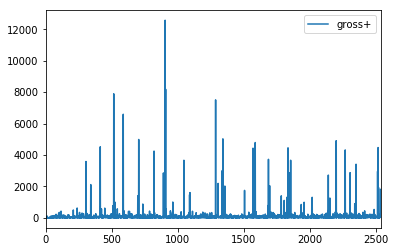

In [51]:
df[['gross+','time']].plot()
plt.show()

In [33]:
ff= './tlogs/201902'
if ff.startswith("./tlogs"):
    print ("yep")

yep


In [18]:
for f in os.walk('./tlogs'): print ("f:",f,"sub:",sub)


f: ('./tlogs', ['201902'], ['.DS_Store']) sub: []
f: ('./tlogs/201902', ['20190202', '20190203', '20190204', '20190205', '20190206', '20190207', '20190208', '20190209', '20190210', '20190211', '20190212', '20190213', '20190214', '20190215', '20190216', '20190217', '20190218', '20190219', '20190220', '20190221', '20190222', '20190223', '20190224', '20190225', '20190226', '20190227', '20190228', '20190301'], ['.DS_Store']) sub: []
f: ('./tlogs/201902/20190202', [], ['checklisting.txt', 'department.txt', 'Department01Discounts.txt', 'Department04Discounts.txt', 'Department06Discounts.txt', 'Department07Discounts.txt', 'Department08Discounts.txt', 'Department09Discounts.txt', 'Department10Discounts.txt', 'Department11Discounts.txt', 'Department12Discounts.txt', 'Department13Discounts.txt', 'Department14Discounts.txt', 'Department15Discounts.txt', 'Department16Discounts.txt', 'Department17Discounts.txt', 'Department19Discounts.txt', 'Department26Discounts.txt', 'dept.txt', 'discountitems.tx

In [ ]:
import os

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        #print os.path.join(subdir, file)
        filepath = subdir + os.sep + file

        if filepath.endswith(".asm"):
            print (filepath)

In [8]:
df=pd.read_pickle('02012019.pkl')

In [10]:
df[df['BANANAS']!=0]

,date,gross+,gross-,items,net,oper,term,time,trans,type,...,PRO BAR MINT CHOC,8213 FENNEL POWDER,OR Cooked Beets,JR Melatonin SR 12,NUT WALNUT,QT Elderbry Loz 36,SW WB Vanilla 12pk,6556 DUTCH COCOA,lvngClyBntonte 8oz,CARDAMOM BITTERS
36,2001-02-19,37.65,0.00,"[[, PASCHA UNSWT CCHIP, 4.99, 15], [, PRIMAVER...",37.65,104,5,09:16,8,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,2001-02-19,108.17,0.00,"[[, FORGER PL CSH YOG, 5.59, 13], [, SO DEL UN...",108.17,42,6,09:20,12,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65,2001-02-19,20.72,0.00,"[[, APPLES FUJI, 2.42, 12], [, 8308KEEMUN BLAC...",20.72,11,1,09:27,7,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73,2001-02-19,144.42,0.00,"[[, WOODSTK BLUEBERRIE, 6.29, 19], [, EVOLUTIO...",144.42,42,6,09:30,17,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74,2001-02-19,17.69,0.00,"[[, COELA ZIPPER TOTE, 9.99, 6], [, BANANAS, 2...",17.69,42,6,09:31,18,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77,2001-02-19,224.03,0.00,"[[, APPLE JUICE, 11.39, 15], [, ORG GAL CLOVER...",224.03,104,5,09:32,21,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89,2001-02-19,80.01,0.00,"[[, MAC HAWAI SEA SALT, 7.99, 15], [, UMLAUT C...",80.01,42,6,09:35,21,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,2001-02-19,86.51,0.00,"[[, FLAVORG VANILLA4oz, 15.49, 15], [, SUGAR P...",86.51,34,8,09:39,12,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,2001-02-19,285.53,0.00,"[[, VH Kids Vibe Choc, 34.4, 1], [, EZ Ultimat...",285.53,11,1,09:40,18,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101,2001-02-19,55.73,0.00,"[[, QRT CAN JAR t101, 1.79, 6], [, QRT CAN JAR...",55.73,42,6,09:41,25,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [200]:
df.columns

Index(['date', 'gross+', 'gross-', 'items', 'net', 'oper', 'term', 'time',
       'trans', 'type'],
      dtype='object')

In [ ]:
plt.scatter(x=df['time'],y=df['gross+'])

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.
